In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Data Processing 

In [2]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
# print('Shape of expenses data', expenses_data.shape)
# print('Shape of sales data', sales_data.shape)
# sales_data

In [3]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [4]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [5]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [6]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [7]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category2

# Remove Outliers

In [8]:
def remove_outliers_zscore(data, threshold=4):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(30)

C:\Users\Berlin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [9]:
category.reset_index(inplace=True)
category = pd.DataFrame(category['Amount'])
Category = category

# Adding Lagged Variables

In [10]:
lags = [1,2,3,4]
for lag in lags:
    category[f'lag{lag}'] = category['Amount'].shift(lag)
category.dropna(inplace=True)
selected_columns = ['Amount', 'lag1', 'lag2', 'lag3','lag4']
category = category[selected_columns]

# Standardization

In [11]:
scaler = MinMaxScaler()
X = scaler.fit_transform(category.drop(category.columns[0], axis=1))
Y = scaler.fit_transform(np.array(category.iloc[:,0]).reshape(-1, 1))

# PCA

In [12]:
n_components = len(lags)
pca = PCA(n_components=n_components)
X = pca.fit_transform(X)

# Train - Test Split

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=True)

# Reshape for LSTM input

In [14]:
X_train_scaled_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_scaled_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val_scaled_reshaped = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Fit the model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [16]:
model = Sequential()
model.add(LSTM(units=550, return_sequences=True, activation='tanh', input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])))
model.add(LSTM(units=250, activation='tanh'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [17]:
cp = ModelCheckpoint('Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])

In [18]:
model.fit(X_train_scaled_reshaped, y_train, validation_data=(X_val_scaled_reshaped, y_val),epochs=500, callbacks=[cp])

Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 0.1598 - root_mean_squared_error: 0.3997INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 101s 101s/step - loss: 0.1598 - root_mean_squared_error: 0.3997 - val_loss: 0.1059 - val_root_mean_squared_error: 0.3254
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 0.1587 - root_mean_squared_error: 0.3984INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 35s 35s/step - loss: 0.1587 - root_mean_squared_error: 0.3984 - val_loss: 0.1051 - val_root_mean_squared_error: 0.3242
Epoch 3/500
1/1 [==============================] - ETA: 0s - loss: 0.1576 - root_mean_squared_error: 0.3970INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 27s 27s/step - loss: 0.1576 - root_mean_squared_error: 0.3970 - val_loss: 0.1043 - val_root_mean_squared_error: 0.3230
Epoch 4/500
1/1 [==============================] - ETA: 0s - loss: 0.1566 - root_mean_squared_error: 0.3957INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 27s 27s/step - loss: 0.1566 - root_mean_squared_error: 0.3957 - val_loss: 0.1036 - val_root_mean_squared_error: 0.3218
Epoch 5/500
1/1 [==============================] - ETA: 0s - loss: 0.1556 - root_mean_squared_error: 0.3944INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 27s 27s/step - loss: 0.1556 - root_mean_squared_error: 0.3944 - val_loss: 0.1028 - val_root_mean_squared_error: 0.3206
Epoch 6/500
1/1 [==============================] - ETA: 0s - loss: 0.1545 - root_mean_squared_error: 0.3931INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 33s 33s/step - loss: 0.1545 - root_mean_squared_error: 0.3931 - val_loss: 0.1020 - val_root_mean_squared_error: 0.3194
Epoch 7/500
1/1 [==============================] - ETA: 0s - loss: 0.1534 - root_mean_squared_error: 0.3917INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 23s 23s/step - loss: 0.1534 - root_mean_squared_error: 0.3917 - val_loss: 0.1012 - val_root_mean_squared_error: 0.3182
Epoch 8/500
1/1 [==============================] - ETA: 0s - loss: 0.1524 - root_mean_squared_error: 0.3903INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 25s 25s/step - loss: 0.1524 - root_mean_squared_error: 0.3903 - val_loss: 0.1005 - val_root_mean_squared_error: 0.3170
Epoch 9/500
1/1 [==============================] - ETA: 0s - loss: 0.1513 - root_mean_squared_error: 0.3890INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 29s 29s/step - loss: 0.1513 - root_mean_squared_error: 0.3890 - val_loss: 0.0997 - val_root_mean_squared_error: 0.3157
Epoch 10/500
1/1 [==============================] - ETA: 0s - loss: 0.1502 - root_mean_squared_error: 0.3876INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 32s 32s/step - loss: 0.1502 - root_mean_squared_error: 0.3876 - val_loss: 0.0989 - val_root_mean_squared_error: 0.3144
Epoch 11/500
1/1 [==============================] - ETA: 0s - loss: 0.1491 - root_mean_squared_error: 0.3862INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 27s 27s/step - loss: 0.1491 - root_mean_squared_error: 0.3862 - val_loss: 0.0981 - val_root_mean_squared_error: 0.3131
Epoch 12/500
1/1 [==============================] - ETA: 0s - loss: 0.1480 - root_mean_squared_error: 0.3848INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 21s 21s/step - loss: 0.1480 - root_mean_squared_error: 0.3848 - val_loss: 0.0972 - val_root_mean_squared_error: 0.3118
Epoch 13/500
1/1 [==============================] - ETA: 0s - loss: 0.1469 - root_mean_squared_error: 0.3833INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 25s 25s/step - loss: 0.1469 - root_mean_squared_error: 0.3833 - val_loss: 0.0964 - val_root_mean_squared_error: 0.3105
Epoch 14/500
1/1 [==============================] - ETA: 0s - loss: 0.1458 - root_mean_squared_error: 0.3819INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 21s 21s/step - loss: 0.1458 - root_mean_squared_error: 0.3819 - val_loss: 0.0956 - val_root_mean_squared_error: 0.3092
Epoch 15/500
1/1 [==============================] - ETA: 0s - loss: 0.1447 - root_mean_squared_error: 0.3804INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 33s 33s/step - loss: 0.1447 - root_mean_squared_error: 0.3804 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3079
Epoch 16/500
1/1 [==============================] - ETA: 0s - loss: 0.1436 - root_mean_squared_error: 0.3789INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 25s 25s/step - loss: 0.1436 - root_mean_squared_error: 0.3789 - val_loss: 0.0940 - val_root_mean_squared_error: 0.3066
Epoch 17/500
1/1 [==============================] - ETA: 0s - loss: 0.1424 - root_mean_squared_error: 0.3774INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 23s 23s/step - loss: 0.1424 - root_mean_squared_error: 0.3774 - val_loss: 0.0932 - val_root_mean_squared_error: 0.3053
Epoch 18/500
1/1 [==============================] - ETA: 0s - loss: 0.1413 - root_mean_squared_error: 0.3759INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 20s 20s/step - loss: 0.1413 - root_mean_squared_error: 0.3759 - val_loss: 0.0924 - val_root_mean_squared_error: 0.3040
Epoch 19/500
1/1 [==============================] - ETA: 0s - loss: 0.1402 - root_mean_squared_error: 0.3744INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 30s 30s/step - loss: 0.1402 - root_mean_squared_error: 0.3744 - val_loss: 0.0916 - val_root_mean_squared_error: 0.3026
Epoch 20/500
1/1 [==============================] - ETA: 0s - loss: 0.1390 - root_mean_squared_error: 0.3728INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 37s 37s/step - loss: 0.1390 - root_mean_squared_error: 0.3728 - val_loss: 0.0908 - val_root_mean_squared_error: 0.3013
Epoch 21/500
1/1 [==============================] - ETA: 0s - loss: 0.1378 - root_mean_squared_error: 0.3713INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 226s 226s/step - loss: 0.1378 - root_mean_squared_error: 0.3713 - val_loss: 0.0900 - val_root_mean_squared_error: 0.2999
Epoch 22/500
1/1 [==============================] - ETA: 0s - loss: 0.1367 - root_mean_squared_error: 0.3697INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 24s 24s/step - loss: 0.1367 - root_mean_squared_error: 0.3697 - val_loss: 0.0892 - val_root_mean_squared_error: 0.2986
Epoch 23/500
1/1 [==============================] - ETA: 0s - loss: 0.1355 - root_mean_squared_error: 0.3681INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 19s 19s/step - loss: 0.1355 - root_mean_squared_error: 0.3681 - val_loss: 0.0883 - val_root_mean_squared_error: 0.2972
Epoch 24/500
1/1 [==============================] - ETA: 0s - loss: 0.1343 - root_mean_squared_error: 0.3665INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 19s 19s/step - loss: 0.1343 - root_mean_squared_error: 0.3665 - val_loss: 0.0875 - val_root_mean_squared_error: 0.2958
Epoch 25/500
1/1 [==============================] - ETA: 0s - loss: 0.1331 - root_mean_squared_error: 0.3648INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 21s 21s/step - loss: 0.1331 - root_mean_squared_error: 0.3648 - val_loss: 0.0867 - val_root_mean_squared_error: 0.2944
Epoch 26/500
1/1 [==============================] - ETA: 0s - loss: 0.1319 - root_mean_squared_error: 0.3631INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 18s 18s/step - loss: 0.1319 - root_mean_squared_error: 0.3631 - val_loss: 0.0859 - val_root_mean_squared_error: 0.2930
Epoch 27/500
1/1 [==============================] - ETA: 0s - loss: 0.1307 - root_mean_squared_error: 0.3615INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 17s 17s/step - loss: 0.1307 - root_mean_squared_error: 0.3615 - val_loss: 0.0850 - val_root_mean_squared_error: 0.2916
Epoch 28/500
1/1 [==============================] - ETA: 0s - loss: 0.1294 - root_mean_squared_error: 0.3598INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 23s 23s/step - loss: 0.1294 - root_mean_squared_error: 0.3598 - val_loss: 0.0842 - val_root_mean_squared_error: 0.2902
Epoch 29/500
1/1 [==============================] - ETA: 0s - loss: 0.1282 - root_mean_squared_error: 0.3580INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 20s 20s/step - loss: 0.1282 - root_mean_squared_error: 0.3580 - val_loss: 0.0834 - val_root_mean_squared_error: 0.2887
Epoch 30/500
1/1 [==============================] - ETA: 0s - loss: 0.1269 - root_mean_squared_error: 0.3563INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 15s 15s/step - loss: 0.1269 - root_mean_squared_error: 0.3563 - val_loss: 0.0825 - val_root_mean_squared_error: 0.2873
Epoch 31/500
1/1 [==============================] - ETA: 0s - loss: 0.1257 - root_mean_squared_error: 0.3545INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 21s 21s/step - loss: 0.1257 - root_mean_squared_error: 0.3545 - val_loss: 0.0817 - val_root_mean_squared_error: 0.2858
Epoch 32/500
1/1 [==============================] - ETA: 0s - loss: 0.1244 - root_mean_squared_error: 0.3527INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 30s 30s/step - loss: 0.1244 - root_mean_squared_error: 0.3527 - val_loss: 0.0808 - val_root_mean_squared_error: 0.2843
Epoch 33/500
1/1 [==============================] - ETA: 0s - loss: 0.1231 - root_mean_squared_error: 0.3509INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)\assets


1/1 [==============================] - 29s 29s/step - loss: 0.1231 - root_mean_squared_error: 0.3509 - val_loss: 0.0800 - val_root_mean_squared_error: 0.2828
Epoch 34/500
1/1 [==============================] - ETA: 0s - loss: 0.1218 - root_mean_squared_error: 0.3490

KeyboardInterrupt: 

# Evaluate Model

In [20]:
from tensorflow.keras.models import load_model
pickledModel = load_model('Models Pickled Flies/Expenses Day Prediction Model(PCA and Normalization)/')

In [21]:
mse = model.evaluate(X_test_scaled_reshaped, y_test, verbose=0)
print(f'Mean Squared Error is {mse}')

Mean Squared Error is [0.07304343581199646, 0.27026548981666565]


In [22]:
mse = pickledModel.evaluate(X_test_scaled_reshaped, y_test, verbose=0)
print(f'Mean Squared Error is {mse}')

Mean Squared Error is [0.07304343581199646, 0.27026548981666565]


In [23]:
train_predictions = model.predict(X_train_scaled_reshaped)
predictions = scaler.inverse_transform(train_predictions).flatten()
train_target = scaler.inverse_transform(y_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': predictions, 'Actuals':train_target})
train_results

1/1 [==============================] - 3s 3s/step


,Train Predictions,Actuals
0,85701.617188,182150.0
1,107503.039062,59100.0
2,63416.238281,108100.0
3,117542.781250,88900.0
4,84171.164062,115500.0
5,99460.546875,90500.0
6,88772.492188,351180.0
7,119367.515625,237900.0
8,57441.871094,63250.0
9,109192.546875,37000.0


In [27]:
category = pd.DataFrame(category2)
category.reset_index(inplace=True)
category =category['Amount']

index_start = 4
index = range(index_start, index_start + len(predictions))
df = pd.DataFrame(predictions, index=index, columns=['Values'])

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

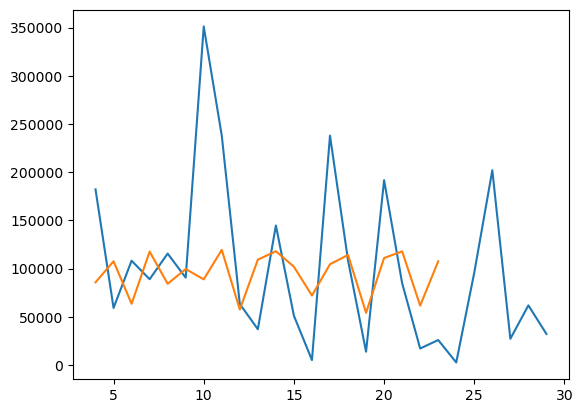

In [28]:
plt.plot(Category['Amount'], label='Original Data')
plt.plot(df)
plt.xlabel

# Make Time Series Predictions

In [20]:
predictions = model.predict(X_test)

array([130889.15, 141946.75,  93238.8 ,  81961.55, 106345.55,  86750.  ])